# Dynamic Time Warping (DTW) - Simple Tutorial

This notebook demonstrates DTW with two simple sine curves.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

plt.rcParams['figure.figsize'] = (12, 6)

## Step 1: Create Two Simple Sine Curves

We'll create two sine curves with **5 points** each:
- **Series X**: Original sine curve
- **Series Y**: Phase-shifted sine curve

Both range from 0 to 1 on the y-axis, x-axis uses whole numbers 0-4.

In [4]:
# X-axis: whole numbers
x_axis = np.array([0, 1, 2, 3, 4])

# Create sine curves (normalized to 0-1 range)
X = (np.sin(x_axis * np.pi / 4) + 1) / 2
Y = (np.sin((x_axis * np.pi / 4) + np.pi/3) + 1) / 2

# Round to 2 decimals for clarity
X = np.round(X, 2)
Y = np.round(Y, 2)

print("Series X:", X)
print("Series Y:", Y)

Series X: [0.5  0.85 1.   0.85 0.5 ]
Series Y: [0.93 0.98 0.75 0.37 0.07]


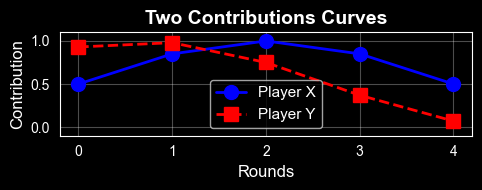

In [27]:
# Plot the two series
plt.figure(figsize=(5, 2))
plt.plot(x_axis, X, 'o-', linewidth=2, markersize=10, label='Player X', color='blue')
plt.plot(x_axis, Y, 's--', linewidth=2, markersize=10, label='Player Y', color='red')
plt.xlabel('Rounds', fontsize=12)
plt.ylabel('Contribution', fontsize=12)
plt.title('Two Contributions Curves', fontsize=14, fontweight='bold')
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(x_axis)
plt.tight_layout()
plt.savefig("Contributions.pdf")
plt.show()

## Step 2: The DTW Formula

### Recurrence Relation:

$$D(i, j) = |X_{i-1} - Y_{j-1}| + \min \begin{cases} D(i-1, j-1) & \text{(match/diagonal)} \\ D(i-1, j) & \text{(insertion/from above)} \\ D(i, j-1) & \text{(deletion/from left)} \end{cases}$$

### Boundary Conditions:
- $D(0, 0) = 0$
- $D(i, 0) = \infty$ for $i > 0$
- $D(0, j) = \infty$ for $j > 0$

### Final DTW Distance:
$$\text{DTW}(X, Y) = D(n, m)$$

where $n$ = length of X, $m$ = length of Y

## Step 3: Initialize the Cost Matrix

In [6]:
n, m = len(X), len(Y)
D = np.full((n+1, m+1), np.inf)
D[0, 0] = 0

print("Initial Cost Matrix D (6x6):")
print("="*50)
df_init = pd.DataFrame(D, 
                       index=['i=0', 'i=1', 'i=2', 'i=3', 'i=4', 'i=5'],
                       columns=['j=0', 'j=1', 'j=2', 'j=3', 'j=4', 'j=5'])
display(df_init)

Initial Cost Matrix D (6x6):


,j=0,j=1,j=2,j=3,j=4,j=5
i=0,0.0,inf,inf,inf,inf,inf
i=1,inf,inf,inf,inf,inf,inf
i=2,inf,inf,inf,inf,inf,inf
i=3,inf,inf,inf,inf,inf,inf
i=4,inf,inf,inf,inf,inf,inf
i=5,inf,inf,inf,inf,inf,inf


## Step 4: Fill the Cost Matrix

In [15]:
calculations = []

for i in range(1, n+1):
    for j in range(1, m+1):

        local_cost = abs(X[i-1] - Y[j-1])

        match = D[i-1, j-1] # diagonal
        insertion = D[i-1, j] # from above
        deletion = D[i, j-1] # from left

        min_prev = min(match, insertion, deletion)

        D[i, j] = local_cost + min_prev
        
        if (i, j) in [(1, 1), (1, 2), (2, 2), (3, 3), (5, 5)]:
            calculations.append({
                'Cell': f'D[{i},{j}]',
                'X value': f'X[{i-1}]={X[i-1]:.2f}',
                'Y value': f'Y[{j-1}]={Y[j-1]:.2f}',
                'Local cost': f'{local_cost:.2f}',
                'Match': f'{match:.2f}',
                'Insert': f'{insertion:.2f}',
                'Delete': f'{deletion:.2f}',
                'Min': f'{min_prev:.2f}',
                'Result': f'{D[i,j]:.2f}'
            })

#print("Example Calculations:")
df_calc = pd.DataFrame(calculations)
#display(df_calc)

## Step 5: Complete Cost Matrix

In [8]:
print("Complete Cost Matrix D:")
df_final = pd.DataFrame(D[1:, 1:], 
                        index=[f'i={i} X={X[i]:.2f}' for i in range(5)],
                        columns=[f'j={j} Y={Y[j]:.2f}' for j in range(5)])
display(df_final.style.format('{:.2f}'))
print(f"\nDTW Distance = D[{n},{m}] = {D[n, m]:.2f}")

Complete Cost Matrix D:


,j=0 Y=0.93,j=1 Y=0.98,j=2 Y=0.75,j=3 Y=0.37,j=4 Y=0.07
i=0 X=0.50,0.43,0.91,1.16,1.29,1.72
i=1 X=0.85,0.51,0.56,0.66,1.14,1.92
i=2 X=1.00,0.58,0.53,0.78,1.29,2.07
i=3 X=0.85,0.66,0.66,0.63,1.11,1.89
i=4 X=0.50,1.09,1.14,0.88,0.76,1.19



DTW Distance = D[5,5] = 1.19


## Step 6: Visualize the Cost Matrix

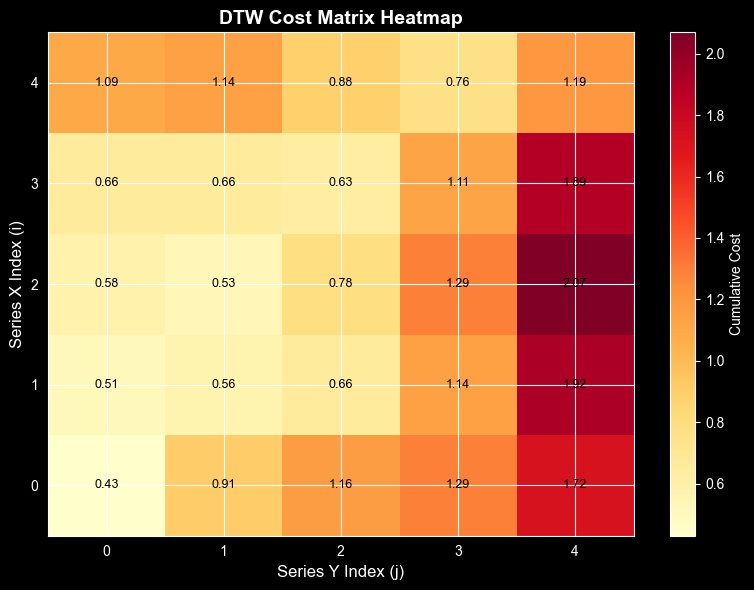

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(D[1:, 1:], cmap='YlOrRd', aspect='auto', origin='lower')
plt.colorbar(label='Cumulative Cost')
plt.xlabel('Series Y Index (j)', fontsize=12)
plt.ylabel('Series X Index (i)', fontsize=12)
plt.title('DTW Cost Matrix Heatmap', fontsize=14, fontweight='bold')
plt.xticks(range(5), range(5))
plt.yticks(range(5), range(5))

for i in range(5):
    for j in range(5):
        plt.text(j, i, f'{D[i+1, j+1]:.2f}', 
                ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
#plt.show()

## Step 7: Find the Optimal Warping Path

In [10]:
path = []
i, j = n, m

while i > 0 or j > 0:
    path.append((i-1, j-1))
    if i == 0:
        j -= 1
    elif j == 0:
        i -= 1
    else:
        candidates = [(D[i-1, j-1], i-1, j-1), (D[i-1, j], i-1, j), (D[i, j-1], i, j-1)]
        _, i, j = min(candidates)

path.reverse()

print("Optimal Warping Path:")
for idx, (i, j) in enumerate(path):
    print(f"Step {idx}: X[{i}] = {X[i]:.2f} <-> Y[{j}] = {Y[j]:.2f}")

path_array = np.array(path)

Optimal Warping Path:
Step 0: X[0] = 0.50 <-> Y[0] = 0.93
Step 1: X[1] = 0.85 <-> Y[0] = 0.93
Step 2: X[2] = 1.00 <-> Y[1] = 0.98
Step 3: X[3] = 0.85 <-> Y[2] = 0.75
Step 4: X[4] = 0.50 <-> Y[3] = 0.37
Step 5: X[4] = 0.50 <-> Y[4] = 0.07


## Step 7b: Understanding Backtracking

### How it works:
At cell D[i,j], we ask: Which cell did I come from?

We compare THREE predecessors:
1. **D[i-1, j-1]** - DIAGONAL: Match X[i-1] with Y[j-1]
2. **D[i-1, j]** - FROM ABOVE: Use X[i-1] but stay at same Y
3. **D[i, j-1]** - FROM LEFT: Use Y[j-1] but stay at same X

Choose whichever has MINIMUM cost!

In [11]:
print("DETAILED BACKTRACKING PROCESS")
print("="*80)

i, j = n, m
step = 0

while i > 0 and j > 0 and step < 10:
    print(f"\nSTEP {step}: At D[{i},{j}] = {D[i,j]:.2f}")
    
    diagonal = D[i-1, j-1]
    from_above = D[i-1, j]
    from_left = D[i, j-1]
    
    print(f"  Diagonal: D[{i-1},{j-1}] = {diagonal:.2f}")
    print(f"  Above: D[{i-1},{j}] = {from_above:.2f}")
    print(f"  Left: D[{i},{j-1}] = {from_left:.2f}")
    
    min_val = min(diagonal, from_above, from_left)
    print(f"  Minimum = {min_val:.2f}")
    
    if diagonal == min_val:
        print(f"  -> Choose DIAGONAL to D[{i-1},{j-1}]")
        i, j = i-1, j-1
    elif from_above == min_val:
        print(f"  -> Choose ABOVE to D[{i-1},{j}]")
        i = i-1
    else:
        print(f"  -> Choose LEFT to D[{i},{j-1}]")
        j = j-1
    
    step += 1

DETAILED BACKTRACKING PROCESS

STEP 0: At D[5,5] = 1.19
  Diagonal: D[4,4] = 1.11
  Above: D[4,5] = 1.89
  Left: D[5,4] = 0.76
  Minimum = 0.76
  -> Choose LEFT to D[5,4]

STEP 1: At D[5,4] = 0.76
  Diagonal: D[4,3] = 0.63
  Above: D[4,4] = 1.11
  Left: D[5,3] = 0.88
  Minimum = 0.63
  -> Choose DIAGONAL to D[4,3]

STEP 2: At D[4,3] = 0.63
  Diagonal: D[3,2] = 0.53
  Above: D[3,3] = 0.78
  Left: D[4,2] = 0.66
  Minimum = 0.53
  -> Choose DIAGONAL to D[3,2]

STEP 3: At D[3,2] = 0.53
  Diagonal: D[2,1] = 0.51
  Above: D[2,2] = 0.56
  Left: D[3,1] = 0.58
  Minimum = 0.51
  -> Choose DIAGONAL to D[2,1]

STEP 4: At D[2,1] = 0.51
  Diagonal: D[1,0] = inf
  Above: D[1,1] = 0.43
  Left: D[2,0] = inf
  Minimum = 0.43
  -> Choose ABOVE to D[1,1]

STEP 5: At D[1,1] = 0.43
  Diagonal: D[0,0] = 0.00
  Above: D[0,1] = inf
  Left: D[1,0] = inf
  Minimum = 0.00
  -> Choose DIAGONAL to D[0,0]


## Step 7c: Visual Backtracking Guide

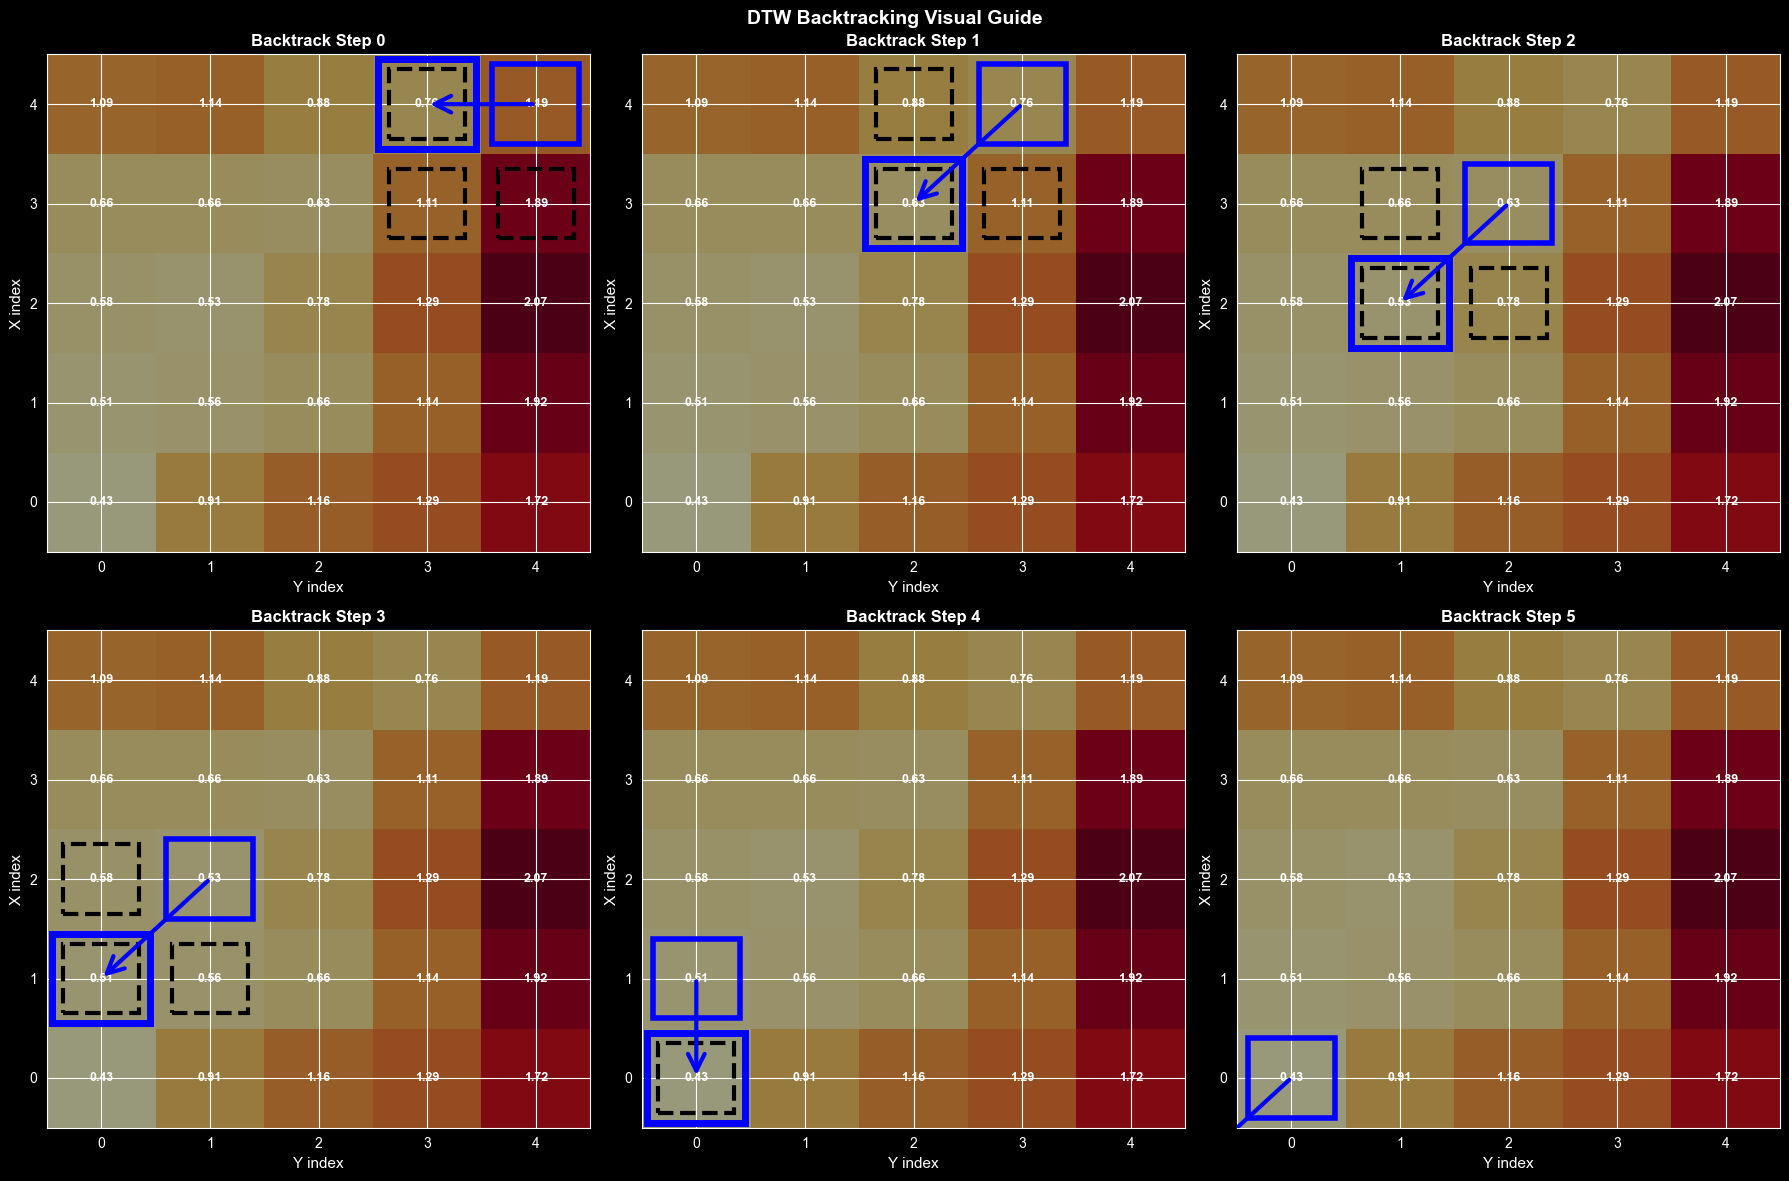

In [36]:
from matplotlib.patches import Rectangle, FancyArrowPatch

# Get backtracking steps
backtrack_steps = []
i, j = n, m
while i > 0 and j > 0:
    candidates = [(i-1, j-1), (i-1, j), (i, j-1)]
    costs = [D[ci, cj] for ci, cj in candidates]
    min_idx = costs.index(min(costs))
    chosen = candidates[min_idx]
    backtrack_steps.append((i, j, candidates, chosen))
    i, j = chosen

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for step_idx in range(min(6, len(backtrack_steps))):
    curr_i, curr_j, candidates, chosen = backtrack_steps[step_idx]
    ax = axes[step_idx]
    
    matrix_to_plot = D[1:, 1:].copy()
    ax.imshow(matrix_to_plot, cmap='YlOrRd', aspect='auto', origin='lower', alpha=0.6)
    
    for i in range(n):
        for j in range(m):
            ax.text(j, i, f'{D[i+1, j+1]:.2f}', ha='center', va='center', fontsize=9, fontweight='bold')
    
    rect_current = Rectangle((curr_j-1-0.4, curr_i-1-0.4), 0.8, 0.8, linewidth=4, edgecolor='blue', facecolor='none')
    ax.add_patch(rect_current)
    
    colors = ['black', 'black', 'black']
    for idx, (cand_i, cand_j) in enumerate(candidates):
        if cand_i >= 1 and cand_j >= 1:
            rect = Rectangle((cand_j-1-0.35, cand_i-1-0.35), 0.7, 0.7, linewidth=3, edgecolor=colors[idx], facecolor='none', linestyle='--')
            ax.add_patch(rect)
    
    if chosen[0] >= 1 and chosen[1] >= 1:
        rect_chosen = Rectangle((chosen[1]-1-0.45, chosen[0]-1-0.45), 0.9, 0.9, linewidth=5, edgecolor='blue', facecolor='none')
        ax.add_patch(rect_chosen)
    
    arrow = FancyArrowPatch((curr_j-1, curr_i-1), (chosen[1]-1, chosen[0]-1), arrowstyle='->', mutation_scale=30, linewidth=3, color='blue', zorder=10)
    ax.add_patch(arrow)
    
    ax.set_xlabel('Y index', fontsize=11)
    ax.set_ylabel('X index', fontsize=11)
    ax.set_title(f'Backtrack Step {step_idx}', fontsize=12, fontweight='bold')
    ax.set_xticks(range(m))
    ax.set_yticks(range(n))

plt.suptitle('DTW Backtracking Visual Guide', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 8: Visualize Path on Matrix

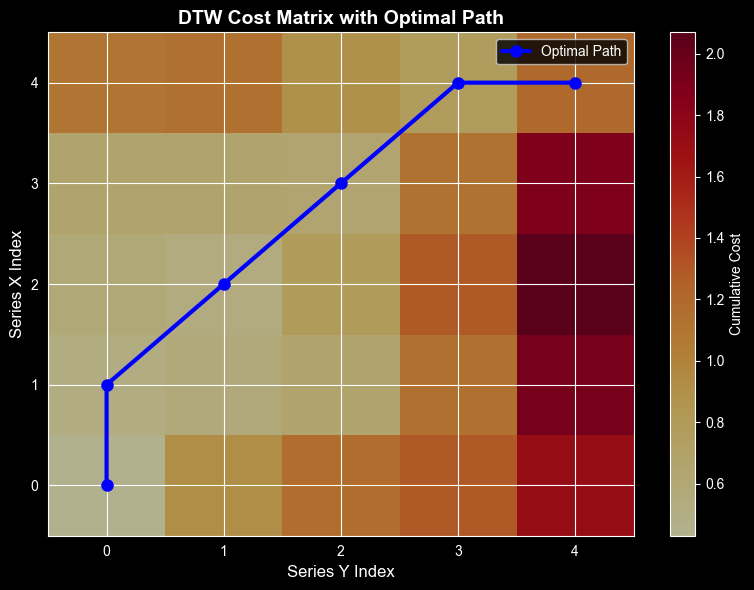

In [13]:
plt.figure(figsize=(8, 6))
plt.imshow(D[1:, 1:], cmap='YlOrRd', aspect='auto', origin='lower', alpha=0.7)
plt.colorbar(label='Cumulative Cost')
plt.plot(path_array[:, 1], path_array[:, 0], 'b-o', linewidth=3, markersize=8, label='Optimal Path')
plt.xlabel('Series Y Index', fontsize=12)
plt.ylabel('Series X Index', fontsize=12)
plt.title('DTW Cost Matrix with Optimal Path', fontsize=14, fontweight='bold')
plt.xticks(range(5), range(5))
plt.yticks(range(5), range(5))
plt.legend()
plt.tight_layout()
plt.show()

## Step 9: Show the Alignment

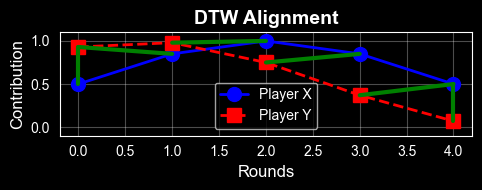

In [30]:
plt.figure(figsize=(5, 2))
plt.plot(x_axis, X, 'o-', linewidth=2, markersize=10, label='Player X', color='blue')
plt.plot(x_axis, Y, 's--', linewidth=2, markersize=10, label='Player Y', color='red')

for i, j in path:
    plt.plot([x_axis[i], x_axis[j]], [X[i], Y[j]], 'green', linewidth=3)

plt.xlabel('Rounds', fontsize=12)
plt.ylabel('Contribution', fontsize=12)
plt.title('DTW Alignment', fontsize=14, fontweight='bold')
plt.ylim(-0.1, 1.1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Step 10: Compare with Euclidean

In [ ]:
euclidean_dist = np.sqrt(np.sum((X - Y)**2))
print("="*50)
print("COMPARISON")
print("="*50)
print(f"Euclidean Distance: {euclidean_dist:.4f}")
print(f"DTW Distance: {D[n, m]:.4f}")
print("\nKey Insight:")
print("- Euclidean assumes fixed alignment")
print("- DTW finds optimal temporal alignment")
print("- DTW handles phase shifts better!")